# MLP for MNIST Image Classification
### This notebook gives a good understanding of to setup a `nn` architecture using Pytorch
### There few elements in designing an MLP 
* Downloading the datasets using in-built pytorch functions
* Converting & Normalizing the dataset for required task
* Setting up the Trainloader and Validation Data loader for batch processing
* Defining the MLP Architecture
* Defining the Loss and Optimizer 
* Prediction and Post-processing

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Contains Activation Function, Losses
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

Set Seed for reproduceability

In [2]:
def set_seed():
    # Set random seed value
    seed_value = 21
    
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
set_seed()

1. Prepare the `Dataloader`

In [6]:
# Download the training dataset without normailzation
raw_transfrom = transforms.Compose([transforms.ToTensor()])
train_set_raw = datasets.FashionMNIST(root='F_MNIST_Data',download=True,train=True,transform=raw_transfrom)

# Compute the mean and std of the dataset
all_pixel = torch.cat([img.view(-1) for img,_ in train_set_raw])
mean = all_pixel.mean().item()
std = all_pixel.std().item()

print(f"Computed Mean: {mean:.4f}, Computed Standard dev: {std:.4f}")

# Define the new transform using the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))
])

# Reload the dataset with proper normalization
train_set = datasets.FashionMNIST(root='F_MNIST_Data',download=True,train=True,transform=transform)
val_set = datasets.FashionMNIST(root='F_MNIST_Data',download=True,train=False,transform=transform)

print(f"Training dataset count: {len(train_set)}, Validation dataset count: {len(val_set)}")

Computed Mean: 0.2860, Computed Standard dev: 0.3530
Training dataset count: 60000, Validation dataset count: 10000


### 2. Create the `Trainloader`

In [7]:
train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set,shuffle=False,batch_size=64)

In [8]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

### 3. Visualize the dataset

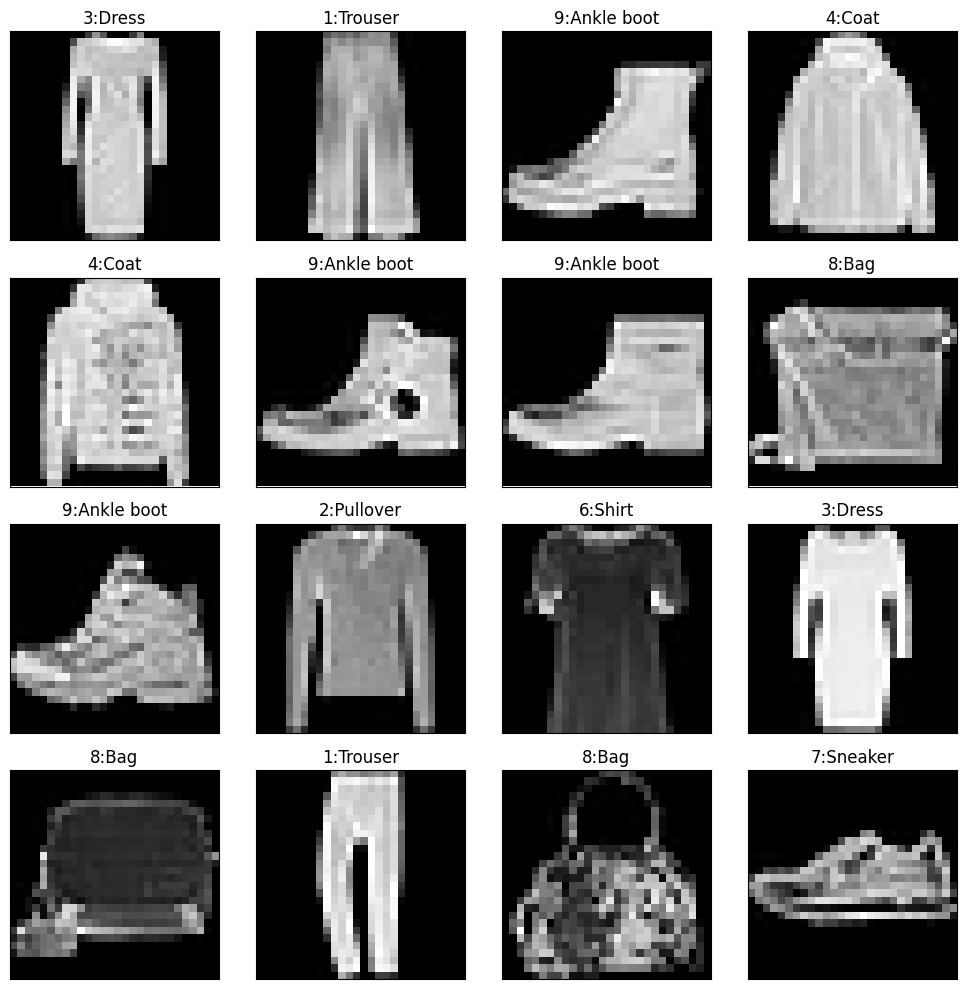

In [11]:
def visualize_image(train_loader,num_of_image=20):
    fig = plt.figure(figsize=(10,10))
    
    # Iterate over the first batch
    images, labels = next(iter(train_loader))

    #To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_of_image / num_rows))

    for idx in range(min(num_of_image, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_image(train_loader, num_of_image=16)

### 4. Model Architecture: DNN

`Deep Neural Network Architecture`

The network architecture shown below has multiple layers. An input layer, five hidden layers, and an output layer. There are several things to note about this architecture.

* Input Data: The image input data is pre-processed (flattened) from a 2-Dimensional array [28x28] to 1-Dimensional vector of length [784x1] where the elements in this input vector are the normalized pixel intensities.

* Hidden Layers: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc.).

* Output Layer: We now have ten neurons in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example.

* Dense Layers: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The weights associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

* Softmax Function: The values from each of the neurons in the output layer are pased through a log_softmax() function to produce a probability score for each of the ten cloth items in the dataset.

6. **Network Output**: The network output ($y’$), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing ($y'$) through the `argmax` function to determine the index of the predicted label.
6. **Loss Function**: The loss function used is **Negative Log Likelihood Loss**. It is computed from the ground truth labels ($y$) and the output log probabilities of the network ($y'$). Note that $y$ and $y'$ are both matrices whose shape is `(Bacth Size, Num Classes)`.

Although the diagram looks quite a bit different from the single-layer perceptron in the linear regression example, it is fundamentally very similar in terms of the processing that takes place during training and prediction. We still compute a loss based on the predicted output of the network and the ground truth label of the inputs. Backpropagation is used to compute the gradient of the loss with respect to the weights in the network. An Adam optimizer is used to update the weights in the neural network.

<img src='https://www.dropbox.com/scl/fi/56ks2wo5pem1m58djqsi8/MLP-with-Fashion-MNIST-Pipeline.png?rlkey=b7is8m2cz222fa6x88px2ll79&st=qvlv5i5f&dl=1' align='center' width='1000'>

In [24]:
# MLP Architecture
# 1: 5 Layer Dense NN
# 2: Use ReLU non-linear activation for hidden layers
# 3: Uses log_softmax() for final output layer, since there are 10 classes (objects: 0 to 9)
# 4: Loss Function -> Negative Log Likelihood Loss
# 5: Dropout to prevent overfitting

class MLP(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.fc0 = nn.Linear(784,512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,num_classes)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self,x):
        # Flatten the input images [28 x 28] --> [784]
        # Remember PyTorch CNN Tensor Dim = [Batch, Channel, Height, Width]
        x = x.view(x.shape[0],-1) # [64,784] --> 64 Images with 784 features
        
        # Specify the Non-linear activation, and dropout
        # 1st Layer
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)
        
        # 2nd Layer
        x = F.relu(self.bn1(self.fc1(x)))
        
        # 3rd Layer
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        # 4th Layer
        x = F.relu(self.bn3(self.fc3(x)))
        
        # 5th Layer
        x = F.log_softmax(self.fc4(x),dim=1)
        
        return x
    
# Instantiate the Model
mlp_model = MLP(num_classes=10)
        
        

In [25]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

### 4. Training Configuration

In [26]:
criterion = F.nll_loss # Negative Log Likelihood Loss
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### 5. Model Training

In [27]:
def train(model,train_loader,criterion,optimizer,DEVICE):
    # Setup or get the model in training mode
    model.train()
    # Load the model in GPU or CPU
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images,labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs,labels)
        loss.backward()
        
        optimizer.step() # Optimizer will tell in which direction to go
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data,dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * (correct_predictions/total_samples)
    
    return avg_loss,accuracy

In [ ]:
# Validation of Model 
def validate(model,val_loader,criterion,DEVICE):
    # Setup or get the model to validation mode
    model.eval()
    # Load the model in GPU or CPU
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss,accuracy

### We train the model for **40 Epochs** and log the training and validation accuracy, losses

In [31]:
def main(model,train_loader,val_loader,epochs,DEVICE):
    train_losses, validation_losses = [],[]
    train_accuracies, validation_accuracies = [],[]
    
    for epoch in range(epochs):
        train_loss,train_accuracy = train(model,train_loader,criterion,optimizer,DEVICE) # We are printing these for each epoch
        validation_loss,validation_accuracy = validate(model,val_loader,criterion,DEVICE) # We are printing these for each epoch
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%")

# Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()   

Epoch 01/40 - Train Loss: 0.5534, Train Accuracy: 80.38% - Val Loss: 0.4764, Val Accuracy: 82.82%
Epoch 02/40 - Train Loss: 0.4261, Train Accuracy: 84.77% - Val Loss: 0.4240, Val Accuracy: 84.76%
Epoch 03/40 - Train Loss: 0.3898, Train Accuracy: 86.00% - Val Loss: 0.3844, Val Accuracy: 86.01%
Epoch 04/40 - Train Loss: 0.3667, Train Accuracy: 86.86% - Val Loss: 0.3650, Val Accuracy: 86.42%
Epoch 05/40 - Train Loss: 0.3542, Train Accuracy: 87.28% - Val Loss: 0.3378, Val Accuracy: 87.68%
Epoch 06/40 - Train Loss: 0.3346, Train Accuracy: 87.87% - Val Loss: 0.3238, Val Accuracy: 88.21%
Epoch 07/40 - Train Loss: 0.3216, Train Accuracy: 88.19% - Val Loss: 0.3057, Val Accuracy: 88.75%
Epoch 08/40 - Train Loss: 0.3121, Train Accuracy: 88.60% - Val Loss: 0.2872, Val Accuracy: 89.33%
Epoch 09/40 - Train Loss: 0.2993, Train Accuracy: 89.05% - Val Loss: 0.2750, Val Accuracy: 89.84%
Epoch 10/40 - Train Loss: 0.2897, Train Accuracy: 89.48% - Val Loss: 0.2671, Val Accuracy: 90.05%
Epoch 11/40 - Train 

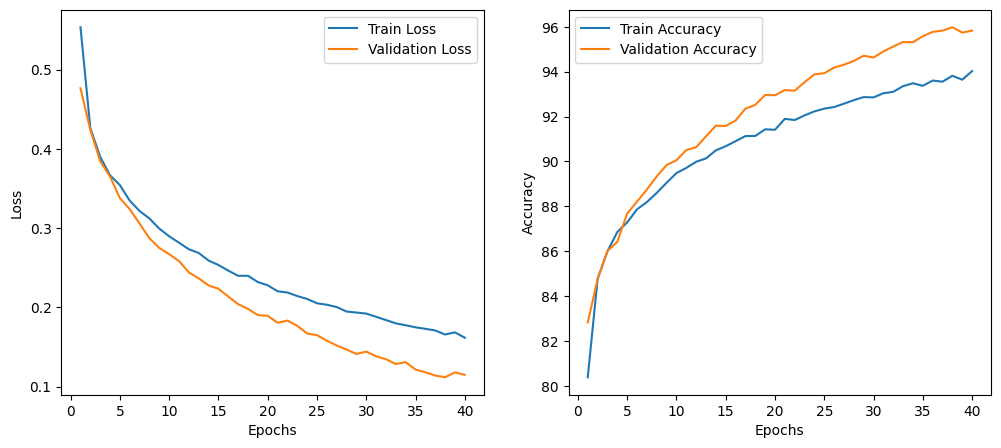

In [32]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

### 5. Inference Resutls

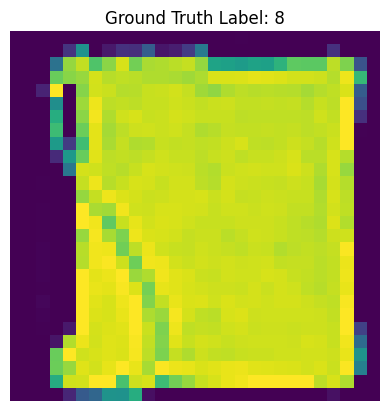

In [34]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [36]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [ ]:
mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 1.000
Class: 9 - Ankle boot, Probability: 0.000
